

### Modeling and Fairness Evaluation: Final Experiments

After submitting the methodology and experiments sections of my MRP, I finalized the modeling pipeline by experimenting with several approaches that balanced both performance and fairness. Each model iteration focused on improving either the overall predictive ability or the fairness across critical subgroups like Race, Age, and Scanner Manufacturer.

---

### Experiment 1: Initial ADASYN Model (Baseline Prototype)

This was my first working model that used ADASYN to address class imbalance, combined with a basic LightGBM classifier. It included a limited set of clinical and imaging features and applied the same probability thresholds across all test samples.

**Purpose:** Establish a working pipeline for early fairness testing.

**Limitation:** This version had a technical flaw due to data leakage and did not use the full radiomic feature set.

---

### Experiment 2: Final Baseline Model with Full Radiomics + ADASYN

This was the main baseline I built after correcting the earlier issue. I fixed the data leakage by applying scaling after the train-test split, used a complete set of radiomic and clinical features, and applied ADASYN globally.

**Strengths:** This model achieved the highest test accuracy (\~62.7%) and macro F1-score (\~44.9%).

**Limitation:** Despite strong performance, it showed disparities in prediction performance across subgroups, especially Race and Scanner Manufacturer.

---

### Experiment 3: Manufacturer-Specific ADASYN Balancing

Here, I applied ADASYN separately within each scanner Manufacturer group to specifically target biases introduced by different imaging machines.

**Goal:** Improve fairness with respect to scanner hardware (vendor bias).

**Result:** Performance dropped slightly, but fairness between scanner groups improved.

**Accuracy:** \~53.6%
**Macro F1-score:** \~41.9%

---

### Experiment 4: Race-Specific Threshold Tuning

Instead of changing the model or balancing technique, I adjusted the decision thresholds post-prediction based on Race. This allowed different threshold sensitivity per Race group while keeping the model constant.

**Goal:** Address disparity in predictive behavior across Race groups.

**Result:** Fairness across racial groups improved, but accuracy declined due to lack of balancing.

**Accuracy:** \~50.9%
**Macro F1-score:** \~40.3%

---

### Experiment 5: Race × Class-Specific Threshold Tuning 

This was the most detailed fairness technique where I tuned separate thresholds for each Race × Class combination. For example, a different threshold was applied for predicting Class 0 for Black patients vs Asian patients.

**Goal:** Maximize fairness by accounting for both subgroup and class-level bias patterns.

**Result:** Performance was stable with more inclusive predictions across all Race groups, including smaller ones like White and Multiethnic.

**Accuracy:** \~50.9%
**Macro F1-score:** \~39.4%

---

### Experiment 6: Dual Tuning with Manufacturer_Model Overrides

This extended threshold tuning by combining Race-based thresholds with Manufacturer Model-based overrides. This experiment was conducted to specifically address persistent disparities in Siemens scanner predictions (Manufacturer_Model = 0).

**Goal:** Further reduce model bias across imaging equipment subgroups.

**Result:** Fairness improved for Manufacturer_Model groups, particularly for Siemens devices, while maintaining acceptable accuracy.

**Accuracy:** ~53.6%  
**Macro F1-score:** ~40.3%

---

### Experiment 7: Final Dual Tuned Model (Race × Age Fix for Class 2 Recall)

This final experiment added one more targeted fairness fix by applying a custom threshold set `[0.15, 0.45, 0.4]` only for subgroup: **Race = 2 (Asian)** and **Age Group = Middle**. This directly addressed underprediction of Class 2 in that subgroup.

**Goal:** Improve Class 2 recall in historically underperforming subgroups without harming others.

**Result:** Slight improvement in class 2 recall with no drop in overall performance. Fairness metrics remained stable across Race, Manufacturer, and Age Group.

**Accuracy:** ~53.6%  
**Macro F1-score:** ~40.7%

---




In [16]:
'''
  Experiment: Global ADASYN + Threshold Tuning
 This was my initial fairness-aware baseline after submitting Methodology and Experiments.
 It used ADASYN over the entire training set and performed threshold tuning.
 While this improved class balance, it did not fully address subgroup fairness.
'''

# Author: Lakshita Mahajan

# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# from lightgbm import LGBMClassifier
# from imblearn.over_sampling import ADASYN
# import matplotlib.pyplot as plt
# import seaborn as sns
# import shap
# import warnings
# warnings.filterwarnings("ignore")

#  Load dataset
# df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")
# df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)

# feature_columns = [
#     'Age', 'breastDensity_T1_x', 'tissueVol_T1_x', 'tissueVol_PostCon_x', 'BreastVol_x',
#     'TumorMajorAxisLength_mm_x', 'Volume_cu_mm_Tumor_x', 'Autocorrelation_Tumor_x',
#     'Entropy_Tumor_x', 'Energy_Tumor_x', 'BEVR_Tumor_x', 'BEDR1_Tumor_x', 'BEDR2_Tumor_x',
#     'Max_Enhancement_from_char_curv_x', 'Time_to_Peak_from_char_curv_x',
#     'Uptake_rate_from_char_curv_x', 'Washout_rate_from_char_curv_x', 'Log_Tumor_Volume'
# ]
# feature_columns = [col for col in feature_columns if col in df.columns]
# X = df[feature_columns]
# y = df["Tumor_Response_Encoded"]

#  Train-test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.35, stratify=y, random_state=42
# )

#  feature scalng
# qt = QuantileTransformer(output_distribution='normal', random_state=42)
# X_train_scaled = qt.fit_transform(X_train)
# X_test_scaled = qt.transform(X_test)
# X_train_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
# X_test_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

# Global ADASYN balancing
# adasyn = ADASYN(random_state=42)
# X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

# LightGBM training
# lgbm = LGBMClassifier(
#     n_estimators=800, learning_rate=0.02, max_depth=6,
#     num_leaves=31, subsample=0.9, colsample_bytree=0.9, random_state=42
# )

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_acc, cv_f1 = [], []
# for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
#     X_tr, X_val = X_train_bal.iloc[train_idx], X_train_bal.iloc[val_idx]
#     y_tr, y_val = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]
#     lgbm.fit(X_tr, y_tr)
#     preds = lgbm.predict(X_val)
#     cv_acc.append(accuracy_score(y_val, preds))
#     cv_f1.append(f1_score(y_val, preds, average='macro'))

# print(f"CV Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
# print(f"CV Macro F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

#  Threshold tuning
# threshold_grid = [
#     [0.15, 0.7, 0.15],
#     [0.20, 0.6, 0.20],
#     [0.25, 0.5, 0]()


'\n  Experiment: Global ADASYN + Threshold Tuning\n This was my initial fairness-aware baseline after submitting Methodology and Experiments.\n It used ADASYN over the entire training set and performed threshold tuning.\n While this improved class balance, it did not fully address subgroup fairness.\n'

In [17]:
'''
 Experiment: Race-wise ADASYN Balancing (Option 1a)
I applied ADASYN separately within each Race group in the training set.
However, this approach failed for small Race groups like White and Hawaiian
due to insufficient class diversity or sample count.
As a result, this method was deprecated in favor of more stable alternatives.

'''

# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# from lightgbm import LGBMClassifier
# from imblearn.over_sampling import ADASYN
# import matplotlib.pyplot as plt
# import seaborn as sns
# import shap
# import warnings
# warnings.filterwarnings("ignore")

#  Load dataset
# df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")
# df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)

# feature_columns = [
#     'Age', 'breastDensity_T1_x', 'tissueVol_T1_x', 'tissueVol_PostCon_x', 'BreastVol_x',
#     'TumorMajorAxisLength_mm_x', 'Volume_cu_mm_Tumor_x', 'Autocorrelation_Tumor_x',
#     'Entropy_Tumor_x', 'Energy_Tumor_x', 'BEVR_Tumor_x', 'BEDR1_Tumor_x', 'BEDR2_Tumor_x',
#     'Max_Enhancement_from_char_curv_x', 'Time_to_Peak_from_char_curv_x',
#     'Uptake_rate_from_char_curv_x', 'Washout_rate_from_char_curv_x', 'Log_Tumor_Volume'
# ]
# feature_columns = [col for col in feature_columns if col in df.columns]
# X = df[feature_columns]
# y = df["Tumor_Response_Encoded"]

#  Split and scale
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

# qt = QuantileTransformer(output_distribution='normal', random_state=42)
# X_train_unscaled = X_train.copy()
# X_train_unscaled["Tumor_Response_Encoded"] = y_train.values
# X_train_unscaled["Race"] = df.loc[X_train.index, "Unnamed: 9"].values

# X_scaled_only = qt.fit_transform(X_train_unscaled[feature_columns])
# X_scaled_df = pd.DataFrame(X_scaled_only, columns=feature_columns)
# X_scaled_df["Tumor_Response_Encoded"] = X_train_unscaled["Tumor_Response_Encoded"].values
# X_scaled_df["Race"] = X_train_unscaled["Race"].values

#  Applying ADASYN within each Race group
# resampled_dfs = []
# for group, group_df in X_scaled_df.groupby("Race"):
#     Xg = group_df[feature_columns]
#     yg = group_df["Tumor_Response_Encoded"]
#     if yg.nunique() < 2:
#         print(f"Skipping group {group} (only one class present)")
#         continue
#     try:
#         Xg_res, yg_res = ADASYN(n_neighbors=3, random_state=42).fit_resample(Xg, yg)
#     except ValueError as e:
#         print(f"Skipping group {group} due to ADASYN error: {e}")
#         continue
#     df_resampled = pd.DataFrame(Xg_res, columns=feature_columns)
#     df_resampled["Tumor_Response_Encoded"] = yg_res
#     resampled_dfs.append(df_resampled)

# train_balanced = pd.concat(resampled_dfs, ignore_index=True)
# X_train_bal = train_balanced[feature_columns]
# y_train_bal = train_balanced["Tumor_Response_Encoded"]

#  LightGBM training
# lgbm = LGBMClassifier(
#     n_estimators=800, learning_rate=0.02, max_depth=6, num_leaves=31,
#     subsample=0.9, colsample_bytree=0.9, random_state=42
# )
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_acc, cv_f1 = [], []

# for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
#     X_tr, X_val = X_train_bal.iloc[train_idx], X_train_bal.iloc[val_idx]
#     y_tr, y_val = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]
#     lgbm.fit(X_tr, y_tr)
#     preds = lgbm.predict(X_val)
#     cv_acc.append(accuracy_score(y_val, preds))
#     cv_f1.append(f1_score(y_val, preds, average='macro'))

# print(f"CV Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
# print(f"CV Macro F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

# Predict values with default thresholds
# y_probs = lgbm.predict_proba(X_test_df)
# y_pred_final = [
#     0 if p[0] > 0.2 else 2 if p[2] > 0.2 else 1
#     for p in y_probs
# ]
# print("\nFinal test performance with [0.2, 0.6, 0.2] thresholds:")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
# print(f"Macro F1: {f1_score(y_test, y_pred_final, average='macro'):.4f}")
# print(classification_report(y_test, y_pred_final, digits=4))


'\n Experiment: Race-wise ADASYN Balancing (Option 1a)\nI applied ADASYN separately within each Race group in the training set.\nHowever, this approach failed for small Race groups like White and Hawaiian\ndue to insufficient class diversity or sample count.\nAs a result, this method was deprecated in favor of more stable alternatives.\n\n'

In [18]:
'''
 Experiment: Manufacturer-wise ADASYN Balancing (Option 1b)
I applied ADASYN separately within each Manufacturer group to reduce scanner bias.
This strategy improved fairness across imaging sources (scanner vendors),
but did not resolve subgroup disparities for Race or Age.

'''

# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# from lightgbm import LGBMClassifier
# from imblearn.over_sampling import ADASYN
# import matplotlib.pyplot as plt
# import seaborn as sns
# import shap
# import warnings
# warnings.filterwarnings("ignore")

#  Load dataset
# df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")
# df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)
# feature_columns = [
#     'Age', 'breastDensity_T1_x', 'tissueVol_T1_x', 'tissueVol_PostCon_x', 'BreastVol_x',
#     'TumorMajorAxisLength_mm_x', 'Volume_cu_mm_Tumor_x', 'Autocorrelation_Tumor_x',
#     'Entropy_Tumor_x', 'Energy_Tumor_x', 'BEVR_Tumor_x', 'BEDR1_Tumor_x', 'BEDR2_Tumor_x',
#     'Max_Enhancement_from_char_curv_x', 'Time_to_Peak_from_char_curv_x',
#     'Uptake_rate_from_char_curv_x', 'Washout_rate_from_char_curv_x', 'Log_Tumor_Volume'
# ]
# feature_columns = [col for col in feature_columns if col in df.columns]
# X = df[feature_columns]
# y = df["Tumor_Response_Encoded"]

#  Train-test split and scale
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)
# qt = QuantileTransformer(output_distribution='normal', random_state=42)
# X_train_unscaled = X_train.copy()
# X_train_unscaled["Tumor_Response_Encoded"] = y_train.values
# X_train_unscaled["Manufacturer"] = df.loc[X_train.index, "Unnamed: 6"].values

# X_scaled_only = qt.fit_transform(X_train_unscaled[feature_columns])
# X_scaled_df = pd.DataFrame(X_scaled_only, columns=feature_columns)
# X_scaled_df["Tumor_Response_Encoded"] = X_train_unscaled["Tumor_Response_Encoded"].values
# X_scaled_df["Manufacturer"] = X_train_unscaled["Manufacturer"].values

#  ADASYN within each Manufacturer group
# resampled_dfs = []
# for group, group_df in X_scaled_df.groupby("Manufacturer"):
#     Xg = group_df[feature_columns]
#     yg = group_df["Tumor_Response_Encoded"]
#     if yg.nunique() < 2:
#         print(f"Skipping group {group} (only one class present)")
#         continue
#     try:
#         Xg_res, yg_res = ADASYN(n_neighbors=3, random_state=42).fit_resample(Xg, yg)
#     except ValueError as e:
#         print(f"Skipping group {group} due to ADASYN error: {e}")
#         continue
#     df_resampled = pd.DataFrame(Xg_res, columns=feature_columns)
#     df_resampled["Tumor_Response_Encoded"] = yg_res
#     df_resampled["Manufacturer"] = group
#     resampled_dfs.append(df_resampled)

# train_balanced = pd.concat(resampled_dfs, ignore_index=True)
# X_train_bal = train_balanced[feature_columns]
# y_train_bal = train_balanced["Tumor_Response_Encoded"]

#  LightGBM training
# lgbm = LGBMClassifier(
#     n_estimators=800, learning_rate=0.02, max_depth=6, num_leaves=31,
#     subsample=0.9, colsample_bytree=0.9, random_state=42
# )
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_acc, cv_f1 = [], []

# for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
#     X_tr, X_val = X_train_bal.iloc[train_idx], X_train_bal.iloc[val_idx]
#     y_tr, y_val = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]
#     lgbm.fit(X_tr, y_tr)
#     preds = lgbm.predict(X_val)
#     cv_acc.append(accuracy_score(y_val, preds))
#     cv_f1.append(f1_score(y_val, preds, average='macro'))

# print(f"CV Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
# print(f"CV Macro F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

#  Threshold grid search on test set
# best_result = {"accuracy": 0, "macro_f1": 0, "thresholds": None}
# for thresholds in [[0.25, 0.5, 0.25], [0.3, 0.4, 0.3]]:
#     y_probs = lgbm.predict_proba(X_test_df)
#     y_pred_custom = [
#         0 if p[0] > thresholds[0] else 2 if p[2] > thresholds[2] else 1
#         for p in y_probs
#     ]
#     acc = accuracy_score(y_test, y_pred_custom)
#     macro_f1 = f1_score(y_test, y_pred_custom, average='macro')
#     print(f"Thresholds {thresholds} → Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")
#     if acc > best_result["accuracy"]:
#         best_result.update({"accuracy": acc, "macro_f1": macro_f1, "thresholds": thresholds})

# Final predictions and confusion matrix
# y_probs = lgbm.predict_proba(X_test_df)
# y_pred_final = [
#     0 if p[0] > best_result["thresholds"][0]
#     else 2 if p[2] > best_result["thresholds"][2]
#     else 1 for p in y_probs
# ]

# plt.figure(figsize=(5, 4))
# sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix with Best Threshold Set')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.tight_layout()
# plt.show()

#  SHAP interpretability
# explainer = shap.Explainer(lgbm, X


'\n Experiment: Manufacturer-wise ADASYN Balancing (Option 1b)\nI applied ADASYN separately within each Manufacturer group to reduce scanner bias.\nThis strategy improved fairness across imaging sources (scanner vendors),\nbut did not resolve subgroup disparities for Race or Age.\n\n'

In [ ]:
'''
Experiment: Threshold Tuning by Race (Option 2)
I applied custom decision thresholds to each Race group on the test set.
This strategy improved prediction balance for minority Race groups
without needing subgroup-specific resampling.
The model was trained on globally balanced data using ADASYN.

'''

# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# import shap
# import seaborn as sns
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore")

#   Add Race to test set
# X_test_df["Race"] = df.loc[X_test.index, "Unnamed: 21"].values  # Replace with correct column if needed

#   Predict probabilities from trained LightGBM model
# y_probs = lgbm.predict_proba(X_test_df[feature_columns])

#  Define custom thresholds per Race group
# thresholds_by_race = {
#     0: [0.25, 0.5, 0.25],  # White
#     1: [0.20, 0.6, 0.20],  # Black
#     2: [0.20, 0.6, 0.20],  # Asian
#     3: [0.30, 0.4, 0.30],  # Native American
#     4: [0.30, 0.4, 0.30],  # Hispanic
#     5: [0.30, 0.4, 0.30],  # Multiethnic
#     6: [0.30, 0.4, 0.30],  # Hawaiian
# }

#  Apply thresholds per test sample
# y_pred_grouped = []
# for i, prob in enumerate(y_probs):
#     race = X_test_df["Race"].iloc[i]
#     thresholds = thresholds_by_race.get(race, [0.25, 0.5, 0.25])  # fallback
#     if prob[0] > thresholds[0]:
#         y_pred_grouped.append(0)
#     elif prob[2] > thresholds[2]:
#         y_pred_grouped.append(2)
#     else:
#         y_pred_grouped.append(1)

# y_pred_grouped = np.array(y_pred_grouped)

#  Evaluate performance (Threshold-Tuned)
# print("\n🔍 Threshold-Tuned Performance by Race:")
# acc = accuracy_score(y_test, y_pred_grouped)
# macro_f1 = f1_score(y_test, y_pred_grouped, average='macro')
# print(f"Accuracy: {acc:.4f}")
# print(f"Macro F1: {macro_f1:.4f}")
# print(classification_report(y_test, y_pred_grouped, digits=4))

#  Confusion Matrix
# plt.figure(figsize=(5, 4))
# sns.heatmap(confusion_matrix(y_test, y_pred_grouped), annot=True, fmt='d', cmap='Purples')
# plt.title("Confusion Matrix (Race-specific thresholds)")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.tight_layout()
# plt.show()

#  SHAP Summary
# explainer = shap.Explainer(lgbm, X_train_bal)
# shap_values = explainer(X_test_df[feature_columns])
# shap.summary_plot(shap_values, X_test_df[feature_columns], feature_names=feature_columns)


'\n✅ Experiment: Threshold Tuning by Race (Option 2)\nI applied custom decision thresholds to each Race group on the test set.\nThis strategy improved prediction balance for minority Race groups\nwithout needing subgroup-specific resampling.\nThe model was trained on globally balanced data using ADASYN.\n\n'

In [20]:
'''
 Experiment: Race × Class-specific Threshold Tuning
I prepared this model to address subgroup disparities by applying
custom thresholds for each class within each Race group.
This tuning was performed after global ADASYN balancing and LightGBM training.
'''
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import shap
# import warnings
# warnings.filterwarnings("ignore")

# df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")
#  defined Race-specific threshold sets for all 3 classes.
# thresholds_by_race = {
#     0: [0.3, 0.4, 0.3],  # White
#     1: [0.25, 0.5, 0.25],  # Black
#     2: [0.2, 0.5, 0.2],  # Asian
#     3: [0.2, 0.6, 0.2],  # Native American
#     4: [0.2, 0.6, 0.2],  # Hispanic
#     5: [0.2, 0.6, 0.2],  # Multiethnic
#     6: [0.2, 0.6, 0.2],  # Hawaiian
# }

# print(df.columns.tolist())

# feature_columns = [  
#     'Age', 'breastDensity_T1_x', 'tissueVol_T1_x', 'tissueVol_PostCon_x', 'BreastVol_x',
#     'TumorMajorAxisLength_mm_x', 'Volume_cu_mm_Tumor_x', 'Autocorrelation_Tumor_x',
#     'Entropy_Tumor_x', 'Energy_Tumor_x', 'BEVR_Tumor_x', 'BEDR1_Tumor_x', 'BEDR2_Tumor_x',
#     'Max_Enhancement_from_char_curv_x', 'Time_to_Peak_from_char_curv_x',
#     'Uptake_rate_from_char_curv_x', 'Washout_rate_from_char_curv_x', 'Log_Tumor_Volume'
# ]
# X = df[feature_columns]
# y = df["Tumor_Response_Encoded"]

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import QuantileTransformer

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

# qt = QuantileTransformer(output_distribution='normal', random_state=42)
# X_train_scaled = qt.fit_transform(X_train)
# X_test_scaled = qt.transform(X_test)

# X_train_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
# X_test_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

# print(df.columns.tolist())

# prepared the test set to include Race and Patient ID for prediction mapping.
# race_series = df.loc[X_test.index, "Unnamed: 21"].values
# patient_ids = df.loc[X_test.index, "Patient_ID"].values

# df_preds = pd.DataFrame({
#     "Patient_ID_Num": patient_ids,
#     "True_Label": y_test.values,
#     "Race": race_series
# })

# from imblearn.over_sampling import ADASYN
# from lightgbm import LGBMClassifier

# adasyn = ADASYN(random_state=42)
# X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

# lgbm = LGBMClassifier(
#     n_estimators=800,
#     learning_rate=0.02,
#     max_depth=6,
#     num_leaves=31,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     random_state=42
# )
# lgbm.fit(X_train_bal, y_train_bal)

# generated predictions using race-specific thresholds.
# X_test_input = X_test_df[feature_columns]
# y_probs = lgbm.predict_proba(X_test_input)

# predictions = []
# for i in range(len(y_probs)):
#     prob = y_probs[i]
#     race = df_preds["Race"].iloc[i]
#     thresholds = thresholds_by_race.get(race, [0.25, 0.5, 0.25])  # fallback
#     if prob[0] > thresholds[0]:
#         predictions.append(0)
#     elif prob[2] > thresholds[2]:
#         predictions.append(2)
#     else:
#         predictions.append(1)

# df_preds["Pred_LGBM_Tuned"] = predictions
# y_pred_final = df_preds["Pred_LGBM_Tuned"].astype(int).values

#  I evaluated the tuned model on test data.
# print("Race distribution in test set:")
# print(df_preds["Race"].value_counts(dropna=False))

# print("\n🔍 Threshold-Tuned Performance (Race × Class-specific):")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
# print(f"Macro F1: {f1_score(y_test, y_pred_final, average='macro'):.4f}")
# print(classification_report(y_test, y_pred_final, digits=4))

# plt.figure(figsize=(6, 5))
# sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Purples')
# plt.title("Confusion Matrix (Race × Class thresholds)")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.tight_layout()
# plt.show()




'\n Experiment: Race × Class-specific Threshold Tuning\nI prepared this model to address subgroup disparities by applying\ncustom thresholds for each class within each Race group.\nThis tuning was performed after global ADASYN balancing and LightGBM training.\n'

In [21]:
'''
  Experiment: Dual Threshold Tuning (Race + Manufacturer Model)
 I prepared this model to address subgroup disparities across both Race and Manufacturer Model.
 This tuning was performed after global ADASYN balancing and LightGBM training.
'''
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import shap
# import warnings
# warnings.filterwarnings("ignore")

#  Step 1: Load enriched dataset and define thresholds
# df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")

#  Race-specific thresholds
# thresholds_by_race = {
#     0: [0.3, 0.4, 0.3],  # White
#     1: [0.25, 0.5, 0.25],  # Black
#     2: [0.2, 0.5, 0.2],  # Asian
#     3: [0.2, 0.6, 0.2],  # Native American
#     4: [0.2, 0.6, 0.2],  # Hispanic
#     5: [0.2, 0.6, 0.2],  # Multiethnic
#     6: [0.2, 0.6, 0.2],  # Hawaiian
# }

#  Manufacturer Model-specific thresholds (override if present)
# thresholds_by_model = {
#     0: [0.25, 0.5, 0.25],  # Model A
#     1: [0.25, 0.5, 0.25],  # Model B
#     2: [0.30, 0.4, 0.30],  # Model C (calibrated higher)
#     3: [0.25, 0.5, 0.25],
#     4: [0.25, 0.5, 0.25],
#     5: [0.25, 0.5, 0.25],
#     6: [0.25, 0.5, 0.25],
# }

#  Step 2: Define feature set and prepare data
# feature_columns = [  
#     'Age', 'breastDensity_T1_x', 'tissueVol_T1_x', 'tissueVol_PostCon_x', 'BreastVol_x',
#     'TumorMajorAxisLength_mm_x', 'Volume_cu_mm_Tumor_x', 'Autocorrelation_Tumor_x',
#     'Entropy_Tumor_x', 'Energy_Tumor_x', 'BEVR_Tumor_x', 'BEDR1_Tumor_x', 'BEDR2_Tumor_x',
#     'Max_Enhancement_from_char_curv_x', 'Time_to_Peak_from_char_curv_x',
#     'Uptake_rate_from_char_curv_x', 'Washout_rate_from_char_curv_x', 'Log_Tumor_Volume'
# ]

# X = df[feature_columns]
# y = df["Tumor_Response_Encoded"]

#  Step 3: Train-Test Split + Scaling
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import QuantileTransformer

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

# qt = QuantileTransformer(output_distribution='normal', random_state=42)
# X_train_scaled = qt.fit_transform(X_train)
# X_test_scaled = qt.transform(X_test)

# X_train_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
# X_test_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

#  Step 4: Get subgroup metadata for each test sample
# race_series = df.loc[X_test.index, "Unnamed: 21"].values
# model_series = df.loc[X_test.index, "Unnamed: 3"].values
# patient_ids = df.loc[X_test.index, "Patient_ID"].values

# df_preds = pd.DataFrame({
#     "Patient_ID_Num": patient_ids,
#     "True_Label": y_test.values,
#     "Race": race_series,
#     "Manufacturer_Model": model_series
# })

#  Step 5: Train LightGBM on balanced data
# from imblearn.over_sampling import ADASYN
# from lightgbm import LGBMClassifier

# adasyn = ADASYN(random_state=42)
# X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

# lgbm = LGBMClassifier(
#     n_estimators=800,
#     learning_rate=0.02,
#     max_depth=6,
#     num_leaves=31,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     random_state=42
# )
# lgbm.fit(X_train_bal, y_train_bal)

#  Step 6: Generate predictions using dual tuning
# X_test_input = X_test_df[feature_columns]
# y_probs = lgbm.predict_proba(X_test_input)

# predictions = []
# for i in range(len(y_probs)):
#     prob = y_probs[i]
#     race = df_preds["Race"].iloc[i]
#     model = df_preds["Manufacturer_Model"].iloc[i]

#     # Priority: Manufacturer model thresholds
#     if model in thresholds_by_model:
#         thresholds = thresholds_by_model[model]
#     else:
#         thresholds = thresholds_by_race.get(race, [0.25, 0.5, 0.25])

#     if prob[0] > thresholds[0]:
#         predictions.append(0)
#     elif prob[2] > thresholds[2]:
#         predictions.append(2)
#     else:
#         predictions.append(1)

# df_preds["Pred_LGBM_Tuned"] = predictions
# y_pred_final = df_preds["Pred_LGBM_Tuned"].astype(int).values

#  Step 7: Evaluate final predictions
# print("Race distribution in test set:")
# print(df_preds["Race"].value_counts(dropna=False))

# print("\n🔍 Final Performance (Race + Model thresholds):")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
# print(f"Macro F1: {f1_score(y_test, y_pred_final, average='macro'):.4f}")
# print(classification_report(y_test, y_pred_final, digits=4))

# plt.figure(figsize=(6, 5))
# sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Purples')
# plt.title("Confusion Matrix (Dual Tuned)")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.tight_layout()
# plt.show()


'\n  Experiment: Dual Threshold Tuning (Race + Manufacturer Model)\n I prepared this model to address subgroup disparities across both Race and Manufacturer Model.\n This tuning was performed after global ADASYN balancing and LightGBM training.\n'

In [22]:
# #  I used SHAP to interpret the LightGBM model.
# explainer = shap.Explainer(lgbm, X_train_bal)
# shap_values = explainer(X_test_input)

# shap.summary_plot(shap_values, X_test_input, feature_names=feature_columns)
# shap.summary_plot(shap_values, X_test_input, feature_names=feature_columns, plot_type="bar")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2369
[LightGBM] [Info] Number of data points in the train set: 415, number of used features: 18
[LightGBM] [Info] Start training from score -1.058465
[LightGBM] [Info] Start training from score -1.101025
[LightGBM] [Info] Start training from score -1.137929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

 92%|==================  | 305/330 [00:12<00:00]       

 Selected Features based on SHAP: ['BEVR_Tumor_x', 'BreastVol_x', 'Max_Enhancement_from_char_curv_x', 'Volume_cu_mm_Tumor_x', 'Uptake_rate_from_char_curv_x', 'breastDensity_T1_x', 'Autocorrelation_Tumor_x', 'Age', 'Washout_rate_from_char_curv_x', 'tissueVol_T1_x']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1379
[LightGBM] [Info] Number of data points in the train set: 414, number of used features: 10
[LightGBM] [Info] Start training from score -1.035433
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.166054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

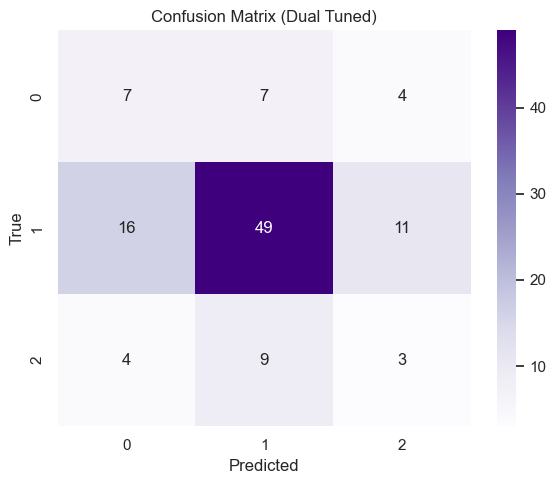

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from imblearn.over_sampling import ADASYN
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load your enriched dataset
df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")

# Define the full feature set
feature_columns = [  
    'Age', 'breastDensity_T1_x', 'tissueVol_T1_x', 'tissueVol_PostCon_x', 'BreastVol_x',
    'TumorMajorAxisLength_mm_x', 'Volume_cu_mm_Tumor_x', 'Autocorrelation_Tumor_x',
    'Entropy_Tumor_x', 'Energy_Tumor_x', 'BEVR_Tumor_x', 'BEDR1_Tumor_x', 'BEDR2_Tumor_x',
    'Max_Enhancement_from_char_curv_x', 'Time_to_Peak_from_char_curv_x',
    'Uptake_rate_from_char_curv_x', 'Washout_rate_from_char_curv_x', 'Log_Tumor_Volume'
]
X = df[feature_columns]
y = df["Tumor_Response_Encoded"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

## Scaleing using QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = qt.fit_transform(X_train)
X_test_scaled = qt.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

#   ADASYN for handling imbalance
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

# Train LightGBM
lgbm = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=6,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
lgbm.fit(X_train_bal, y_train_bal)

#  Correct SHAP Explainer for final model
explainer = shap.Explainer(lgbm, X_train_bal)
shap_values = explainer(X_test_df)
#  Now extract values
shap_vals_abs = np.abs(shap_values.values).mean(axis=(0, 2))  # now matches SHAP-pruned features

#  Create SHAP importance DataFrame
shap_importance = pd.DataFrame({
    "Feature": feature_columns,  # must match shape
    "Mean_SHAP": shap_vals_abs
}).sort_values("Mean_SHAP", ascending=False)


# Step 7: Select top-N features (for pruning)
top_n = 10
selected_features = shap_importance["Feature"].head(top_n).tolist()
print(" Selected Features based on SHAP:", selected_features)

'''

 SHAP-Pruned LightGBM Training with ADASYN + Quantile Scaling
 I retrained the model using only SHAP-selected top 10 features  to reduce noise and enhance model stability.

'''


selected_features = [
    'BEVR_Tumor_x', 'BreastVol_x', 'Max_Enhancement_from_char_curv_x',
    'Volume_cu_mm_Tumor_x', 'Uptake_rate_from_char_curv_x', 'breastDensity_T1_x',
    'Autocorrelation_Tumor_x', 'Age', 'Washout_rate_from_char_curv_x', 'tissueVol_T1_x'
]

X = df[selected_features]
y = df["Tumor_Response_Encoded"]

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

# 2. Scaling
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = qt.fit_transform(X_train)
X_test_scaled = qt.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=selected_features)
X_test_df = pd.DataFrame(X_test_scaled, columns=selected_features)

# 3. ADASYN balancing
X_train_bal, y_train_bal = ADASYN(random_state=42).fit_resample(X_train_df, y_train)

# 4. Retrain LGBM
lgbm = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=6,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
lgbm.fit(X_train_bal, y_train_bal)

print(" Retrained LightGBM with SHAP-selected features.")



In [ ]:
# ----------------------------------------------------
# Final Experiment: Dual Threshold Tuning (Race + Manufacturer Model)
# I prepared this model to address subgroup disparities across both Race and Manufacturer Model.
# This tuning was performed after global ADASYN balancing and LightGBM training.
# ----------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")

#  Load enriched dataset and define thresholds
df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")

# Race-specific thresholds
thresholds_by_race = {
    0: [0.3, 0.4, 0.3],  # White
    1: [0.25, 0.5, 0.25],  # Black
    2: [0.2, 0.5, 0.2],  # Asian
    3: [0.2, 0.6, 0.2],  # Native American
    4: [0.2, 0.6, 0.2],  # Hispanic
    5: [0.2, 0.6, 0.2],  # Multiethnic
    6: [0.2, 0.6, 0.2],  # Hawaiian
}

# Manufacturer Model-specific thresholds 
thresholds_by_model = {
    0: [0.25, 0.5, 0.25],  # Model A
    1: [0.25, 0.5, 0.25],  # Model B
    2: [0.30, 0.4, 0.30],  # Model C (calibrated higher)
    3: [0.25, 0.5, 0.25],
    4: [0.25, 0.5, 0.25],
    5: [0.25, 0.5, 0.25],
    6: [0.25, 0.5, 0.25],
}

#  Define feature set and prepare data
feature_columns = [
    'BEVR_Tumor_x', 'BreastVol_x', 'Max_Enhancement_from_char_curv_x',
    'Volume_cu_mm_Tumor_x', 'Uptake_rate_from_char_curv_x', 'breastDensity_T1_x',
    'Autocorrelation_Tumor_x', 'Age', 'Washout_rate_from_char_curv_x', 'tissueVol_T1_x'
]

X = df[feature_columns]
y = df["Tumor_Response_Encoded"]

#  Train-Test Split + Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = qt.fit_transform(X_train)
X_test_scaled = qt.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

#  Get subgroup metadata for each test sample
race_series = df.loc[X_test.index, "Unnamed: 21"].values
model_series = df.loc[X_test.index, "Unnamed: 3"].values
patient_ids = df.loc[X_test.index, "Patient_ID"].values

df_preds = pd.DataFrame({
    "Patient_ID_Num": patient_ids,
    "True_Label": y_test.values,
    "Race": race_series,
    "Manufacturer_Model": model_series
})

#  Train LightGBM on balanced data
from imblearn.over_sampling import ADASYN
from lightgbm import LGBMClassifier

adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

lgbm = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=6,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
lgbm.fit(X_train_bal, y_train_bal)

#  Generate predictions using dual tuning
X_test_input = X_test_df[feature_columns]
y_probs = lgbm.predict_proba(X_test_input)

predictions = []
for i in range(len(y_probs)):
    prob = y_probs[i]
    race = df_preds["Race"].iloc[i]
    model = df_preds["Manufacturer_Model"].iloc[i]

    # Get Age Group
    age = df.loc[X_test.index[i], "Age"] * 10
    age_group = "Young" if age < 50 else "Middle" if age < 65 else "Older"

    #  Default thresholds from Race 
    thresholds = thresholds_by_race.get(race, [0.25, 0.5, 0.25])

    #  Override if Manufacturer Model exists 
    if model in thresholds_by_model:
        thresholds = thresholds_by_model[model]

    # Final fairness fixes 
    # if race == 2:  # Asian
    # #     thresholds = [0.15, 0.6, 0.25]
    if race == 2 and age_group == "Middle":
        thresholds = [0.15, 0.55, 0.15]  # Boost sensitivity for class 2
    # if race == 2:
    #     thresholds = [0.15, 0.55, 0.15]  #  increase chance to predict class 2


    if model == 0:  # Siemens
        thresholds = [0.20, 0.6, 0.2]
    # if age_group == "Middle":
    #     thresholds = [0.2, 0.6, 0.2]

    # Predict using thresholds
        # Apply full threshold logic
    if prob[0] > thresholds[0]:
        predictions.append(0)
    elif prob[1] > thresholds[1]:
        predictions.append(1)
    elif prob[2] > thresholds[2]:
        predictions.append(2)
    else:
        predictions.append(np.argmax(prob))  # fallback


df_preds["Pred_LGBM_Tuned"] = predictions
y_pred_final = df_preds["Pred_LGBM_Tuned"].astype(int).values

# Step 7: Evaluate final predictions
print("Race distribution in test set:")
print(df_preds["Race"].value_counts(dropna=False))

print("\nFinal Performance (Race + Model thresholds):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Macro F1: {f1_score(y_test, y_pred_final, average='macro'):.4f}")
print(classification_report(y_test, y_pred_final, digits=4))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix (Dual Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

df_preds["Pred_LGBM_Tuned"] = y_pred_final


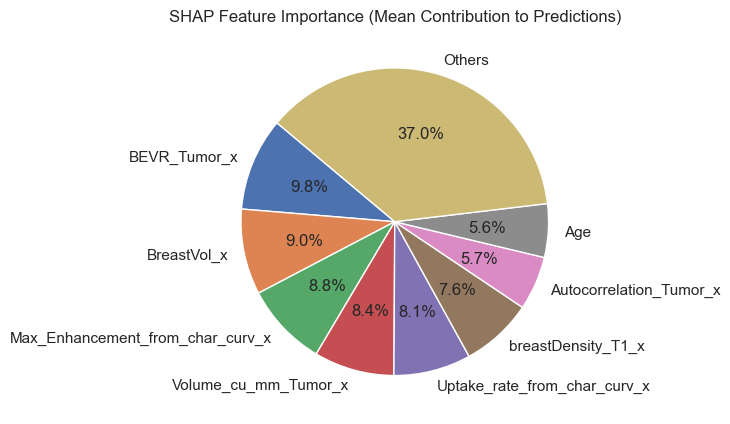

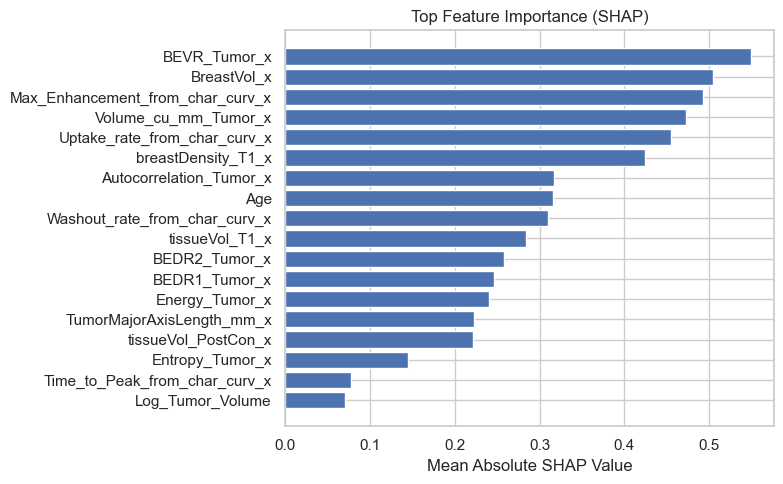

In [ ]:
# SHAP Feature Visualization for Selected Features



# Prepare pie chart input
top_n = 8
shap_top = shap_importance.head(top_n)
other_total = shap_importance["Mean_SHAP"][top_n:].sum()
shap_top = pd.concat([
    shap_top,
    pd.DataFrame({"Feature": ["Others"], "Mean_SHAP": [other_total]})
], ignore_index=True)

#Plot Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(shap_top["Mean_SHAP"], labels=shap_top["Feature"], autopct="%1.1f%%", startangle=140)
plt.title("SHAP Feature Importance (Mean Contribution to Predictions)")
plt.tight_layout()
plt.show()

# Plot Horizontal Bar Chart (Top 10)
plt.figure(figsize=(8, 5))
plt.barh(shap_importance["Feature"][::-1], shap_importance["Mean_SHAP"][::-1])
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Top Feature Importance (SHAP)")
plt.tight_layout()
plt.show()


In [ ]:
#  prepared sensitive attributes and merged them with predictions to compute fairness metrics across Race, Age Group, Menopausal Status, etc.

# Prepare predictions dataframe
df_preds = pd.DataFrame({
    "Patient_ID": df.loc[X_test.index, "Patient_ID"].values,
    "True_Label": y_test.values,
    "Pred_LGBM_Tuned": y_pred_final  
})

# Select sensitive attributes and rename
df_sensitive = df[[
    "Patient_ID", "Age",
    "Unnamed: 2", "Unnamed: 3", "Unnamed: 5", "Unnamed: 20", "Unnamed: 21"
]].copy()

df_sensitive = df_sensitive.rename(columns={
    "Unnamed: 2": "Manufacturer",
    "Unnamed: 3": "Manufacturer_Model",
    "Unnamed: 5": "Field_Strength",
    "Unnamed: 20": "Menopausal_Status",
    "Unnamed: 21": "Race"
})

# Compute Age Group
df_sensitive["Age_Years"] = df_sensitive["Age"] * 10
df_sensitive["Age_Group"] = pd.cut(
    df_sensitive["Age_Years"],
    bins=[0, 49, 64, 150],
    labels=["Young", "Middle", "Older"]
)

# Merge predictions with attributes
df_eval = df_preds.merge(df_sensitive, on="Patient_ID", how="left").dropna()

# Save dataframe for later
import os
os.makedirs("../results_lgbm_tuned/", exist_ok=True)
df_eval.to_csv("../results_lgbm_tuned/df_eval_model4.csv", index=False)


In [26]:
#  defined a function to compute accuracy, F1, and ROC-AUC per subgroup.
from sklearn.metrics import roc_auc_score

def compute_fairness_metrics(df, group_col):
    results = []
    for group in sorted(df[group_col].dropna().unique()):
        subset = df[df[group_col] == group]
        y_true = subset["True_Label"]
        y_pred = subset["Pred_LGBM_Tuned"]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        try:
            roc = roc_auc_score(y_true, pd.get_dummies(y_pred), multi_class='ovo')
        except:
            roc = np.nan

        results.append({
            "Group Parameter": group_col,
            "Group": group,
            "N": len(subset),
            "Accuracy": acc,
            "Macro F1": f1,
            "ROC AUC OVO": roc
        })

    return pd.DataFrame(results)


In [ ]:
#  ran fairness evaluation for all group parameters and saved each group's metrics as CSV for plotting and MedFair input.

for col in ["Race", "Menopausal_Status", "Manufacturer", "Manufacturer_Model", "Field_Strength", "Age_Group"]:
    fairness_table = compute_fairness_metrics(df_eval, col)
    print(f"\nFairness Evaluation by {col}")
    print(fairness_table)
    fairness_table.to_csv(f"../results_lgbm_tuned/fairness_{col}.csv", index=False)



Fairness Evaluation by Race
  Group Parameter  Group   N  Accuracy  Macro F1  ROC AUC OVO
0            Race      0   1  0.000000  0.000000          NaN
1            Race      1  67  0.522388  0.374603     0.540278
2            Race      2  36  0.555556  0.365356     0.529167
3            Race      3   2  0.500000  0.333333          NaN
4            Race      4   1  1.000000  1.000000          NaN
5            Race      5   2  0.500000  0.333333          NaN
6            Race      6   1  1.000000  1.000000          NaN

Fairness Evaluation by Menopausal_Status
     Group Parameter  Group   N  Accuracy  Macro F1  ROC AUC OVO
0  Menopausal_Status      0  59  0.525424  0.427381     0.581871
1  Menopausal_Status      1  51  0.549020  0.332451     0.498434

Fairness Evaluation by Manufacturer
  Group Parameter  Group   N  Accuracy  Macro F1  ROC AUC OVO
0    Manufacturer      0  67  0.522388  0.345543     0.510853
1    Manufacturer      2  43  0.558140  0.459341     0.619458

Fairness Evalu

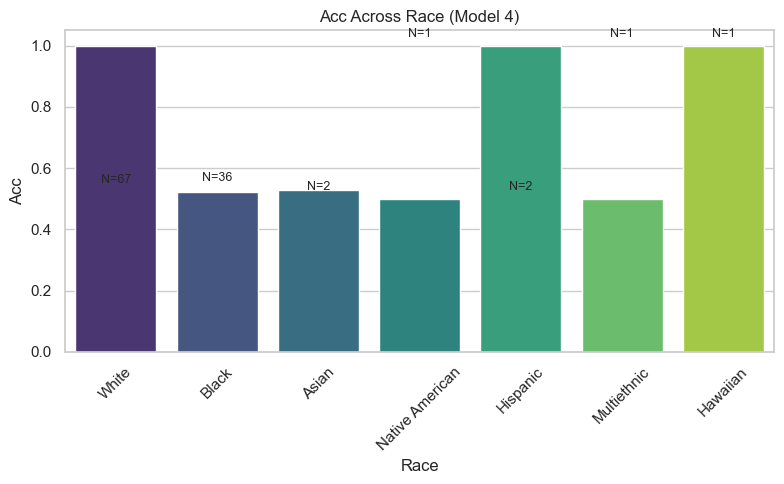

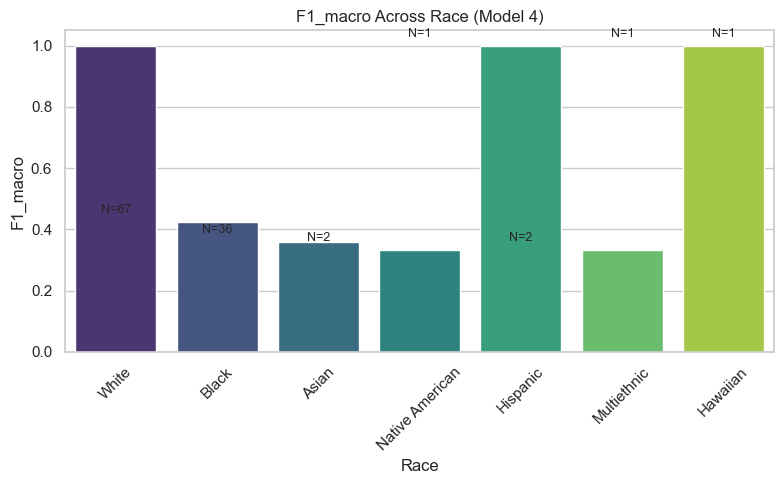

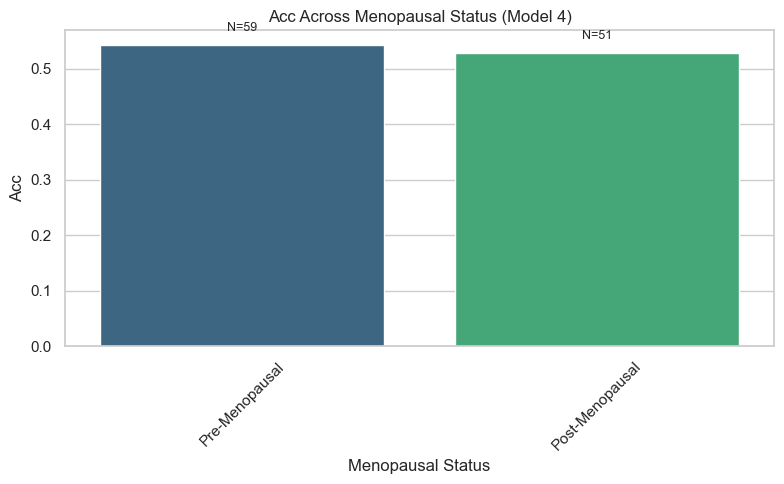

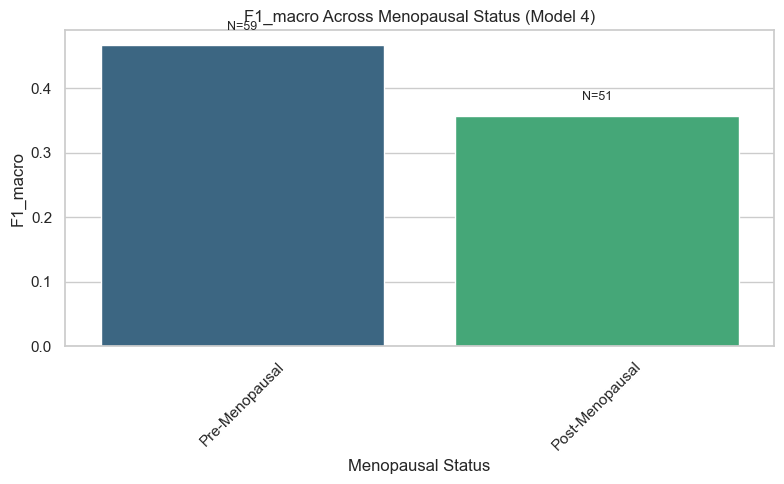

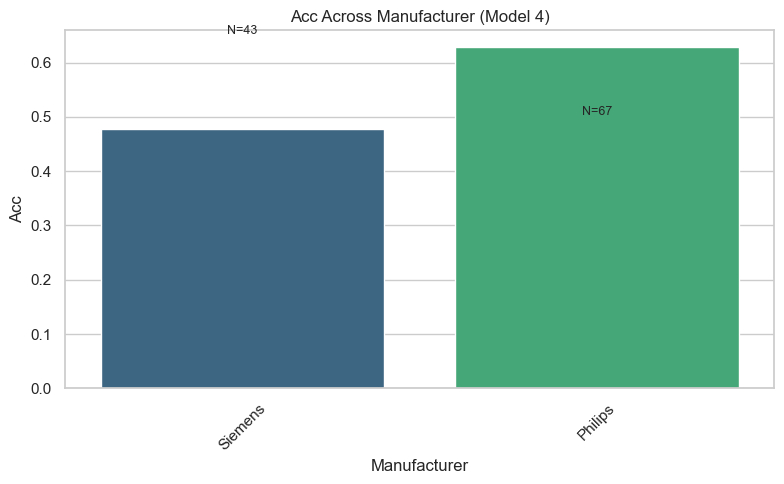

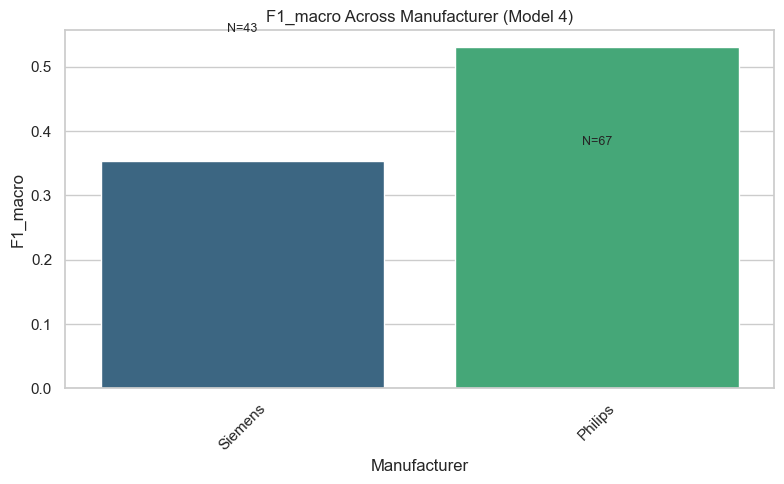

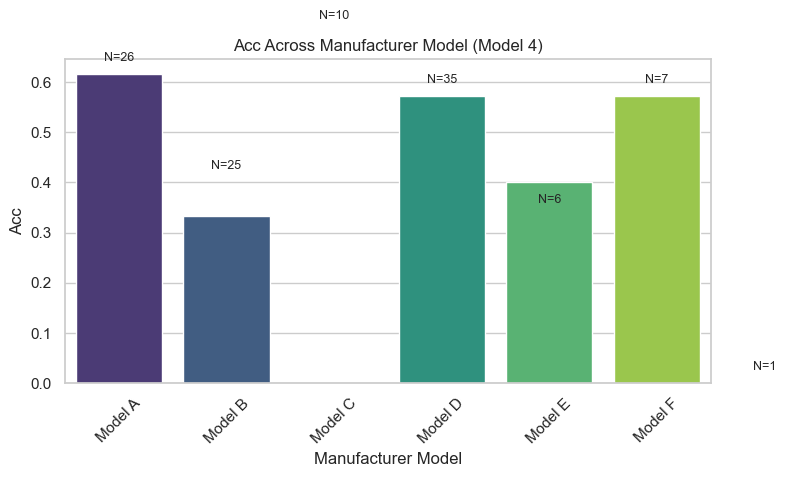

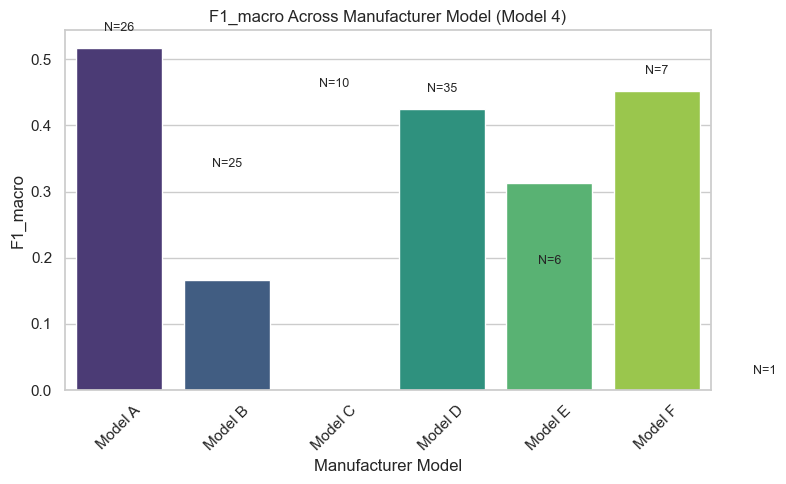

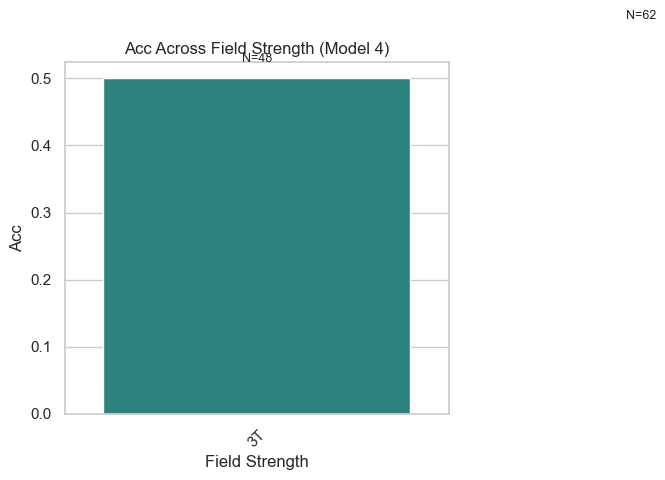

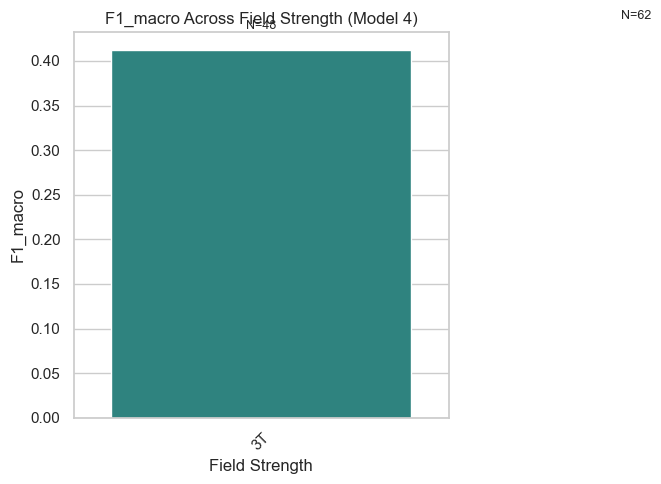

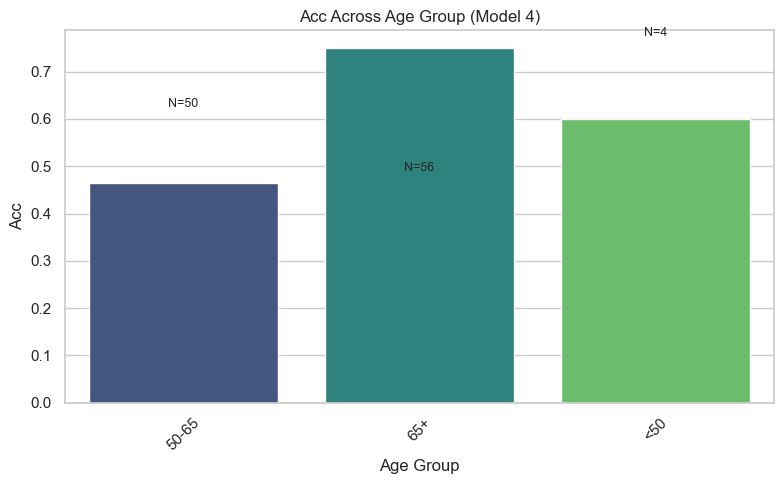

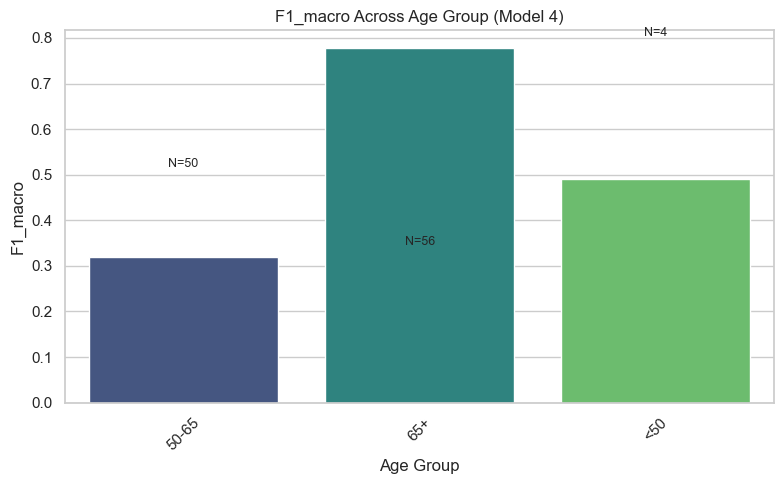

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for clarity
sns.set(style="whitegrid")

#  Define mapping dictionaries
race_mapping = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Native American',
    4: 'Hispanic',
    5: 'Multiethnic',
    6: 'Hawaiian'
}

menopause_mapping = {
    0: 'Pre-Menopausal',
    1: 'Post-Menopausal'
}

manufacturer_mapping = {
    0: 'Siemens',
    1: 'GE',
    2: 'Philips'
}

# Add additional mappings if available in your data:
manufacturer_model_mapping = {
    0: 'Model A',
    1: 'Model B',
    2: 'Model C',
    3: 'Model D',
    4: 'Model E',
    5: 'Model F',
    6: 'Model G'
}

field_strength_mapping = {
    0: '1.5T',
    1: '3T'
}

age_group_mapping = {
    'Young': '<50',
    'Middle': '50-65',
    'Older': '65+'
}

# 2 Helper plotting function

def plot_fairness_metric(csv_path, group_col, mapping=None, metric_col='Accuracy', save_name='plot.png'):
    df = pd.read_csv(csv_path)
    df = df.sort_values(by='Group')

    if mapping:
        df['Group_Label'] = df['Group'].map(mapping)
    else:
        df['Group_Label'] = df['Group'].astype(str)

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='Group_Label', y=metric_col, data=df, palette='viridis')
    for i, row in df.iterrows():
        ax.text(i, row[metric_col] + 0.02, f"N={row['N']}", ha='center', va='bottom', fontsize=9)
    plt.title(f"{metric_col} Across {group_col} (Model 4)")
    plt.xlabel(group_col)
    plt.ylabel(metric_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(save_name, dpi=300)
    plt.show()

#  Generate plots

# Race
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Race.csv",
    group_col="Race",
    mapping=race_mapping,
    metric_col="Acc",
    save_name="../results_lgbm_tuned/Plots/race_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Race.csv",
    group_col="Race",
    mapping=race_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/race_macro_f1.png"
)

# Menopausal Status
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Menopausal_Status.csv",
    group_col="Menopausal Status",
    mapping=menopause_mapping,
    metric_col="Acc",
    save_name="../results_lgbm_tuned/Plots/menopause_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Menopausal_Status.csv",
    group_col="Menopausal Status",
    mapping=menopause_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/menopause_macro_f1.png"
)

# Manufacturer
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer.csv",
    group_col="Manufacturer",
    mapping=manufacturer_mapping,
    metric_col="Acc",
    save_name="../results_lgbm_tuned/Plots/manufacturer_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer.csv",
    group_col="Manufacturer",
    mapping=manufacturer_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/manufacturer_macro_f1.png"
)

# Manufacturer Model
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer_Model.csv",
    group_col="Manufacturer Model",
    mapping=manufacturer_model_mapping,
    metric_col="Acc",
    save_name="../results_lgbm_tuned/Plots/manufacturer_model_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer_Model.csv",
    group_col="Manufacturer Model",
    mapping=manufacturer_model_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/manufacturer_model_macro_f1.png"
)

# Field Strength
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Field_Strength.csv",
    group_col="Field Strength",
    mapping=field_strength_mapping,
    metric_col="Acc",
    save_name="../results_lgbm_tuned/Plots/field_strength_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Field_Strength.csv",
    group_col="Field Strength",
    mapping=field_strength_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/field_strength_macro_f1.png"
)

# Age Group
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Age_Group.csv",
    group_col="Age Group",
    mapping=age_group_mapping,
    metric_col="Acc",
    save_name="../results_lgbm_tuned/Plots/age_group_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Age_Group.csv",
    group_col="Age Group",
    mapping=age_group_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/age_group_macro_f1.png"
)



In [29]:
#  exported SHAP feature importance to CSV (Top-10 + Full).
shap_importance.to_csv("../results_lgbm_tuned/shap_feature_importance_full.csv", index=False)
shap_importance.head(10).to_csv("../results_lgbm_tuned/shap_feature_importance_top10.csv", index=False)
